<a href="https://colab.research.google.com/github/AUT-Student/NLP-HW2/blob/main/NLP_HW2_Q1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><b>In the name of God</b></center>

<b>Course</b>: Natural Language Processing
<br>
<b>Description:</b> HomeWork 2 | Question 1
<br>
<b>Developer</b>: Alireza Mazochi (400131075)

# Libraries

In [ ]:
!pip install gensim --upgrade
!pip install python-bidi
!pip install arabic_reshaper

     |████████████████████████████████| 24.1 MB 1.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

from gensim.models import Word2Vec, TfidfModel, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim import corpora

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

from bidi.algorithm import get_display
import arabic_reshaper

# Dataset

In [ ]:
!gdown 1-86CqCHek-U1iH5nW30RfnFU0PYmdhKB

Downloading...
From: https://drive.google.com/uc?id=1-86CqCHek-U1iH5nW30RfnFU0PYmdhKB
To: /content/train.csv
100% 20.1M/20.1M [00:00<00:00, 247MB/s]


In [ ]:
!gdown 1YzRlYyye_KoEw7_q9NARiCwl3Cn-EH3J

Downloading...
From: https://drive.google.com/uc?id=1YzRlYyye_KoEw7_q9NARiCwl3Cn-EH3J
To: /content/test.csv
100% 2.03M/2.03M [00:00<00:00, 134MB/s]


In [ ]:
train_data = pd.read_csv("/content/train.csv")
test_data = pd.read_csv("/content/test.csv")

In [ ]:
preprocess = lambda x : re.sub(r'!|@|:|#|؟|.\|,|;|،|؛|-|\*', '', x)

In [ ]:
train_data["article"] = train_data["article"].map(preprocess)
test_data["article"] = test_data["article"].map(preprocess)

# Word Representation

In [ ]:
train_sentences = train_data["article"].values

In [ ]:
train_sentences = [sentence.split() for sentence in train_sentences]

In [ ]:
word2vec_model = Word2Vec(sentences=train_sentences, vector_size=300,
                          sg=1, min_count=1, epochs=5)

# Document Representation

## TF-IDF

In [ ]:
dictionary = corpora.Dictionary()

In [ ]:
train_sentences_bow = [dictionary.doc2bow(sentence, allow_update=True) for sentence in train_sentences]

In [ ]:
tfidf_model = TfidfModel(train_sentences_bow)

## Word2Vec & TF-IDF

In [ ]:
class Word2VecTfIdf():
  def __init__(self, word2vec_model, tfidf_model, dictionary):
    self.word2vec_model = word2vec_model
    self.tfidf_model = tfidf_model
    self.dictionary = dictionary

  def text_vector(self, text):
    text_words = text.split()
    text_bow = self.dictionary.doc2bow(text_words)
    tfidf_output = self.tfidf_model[text_bow]

    sum_weight = 0
    sum_vector = np.zeros(self.word2vec_model.vector_size)

    for id, weight in tfidf_output:
      word = self.dictionary[id]
      word_vector = self.word2vec_model.wv[word]

      sum_vector += weight * word_vector
      sum_weight += weight

    avg_vector = (1/sum_weight) * sum_vector
    return avg_vector

In [ ]:
word2vec_tfidf_model = Word2VecTfIdf(word2vec_model=word2vec_model,
                                     tfidf_model=tfidf_model,
                                     dictionary=dictionary)

## Doc2Vec

In [ ]:
train_sentences_tagged = [TaggedDocument(sentence, [i]) for i, sentence in enumerate(train_sentences)]

In [ ]:
doc2vec_model = Doc2Vec(documents=train_sentences_tagged, epochs=5, vector_size=300)

# Similar Documents

In [ ]:
tfidf_vectors = {}
doc2vec_vectors = {}

In [ ]:
for i, data in train_data.iterrows():
  doc_id = data["id"]
  text = data["article"]

  tfidf_vector = word2vec_tfidf_model.text_vector(text)
  tfidf_vectors[doc_id] = tfidf_vector

  doc2vec_vector = doc2vec_model.dv[i]
  doc2vec_vectors[doc_id] = doc2vec_vector

In [ ]:
for test_doc_id in ["Doc1", "Doc3", "Doc5", "Doc25", "Doc36"]:
  print(f"Doc ID = {test_doc_id}")
  
  test_text = test_data[test_data["id"]==test_doc_id]["article"].values[0]

  print(f"Original Text\n {test_text}")

  test_tfidf_vector = word2vec_tfidf_model.text_vector(test_text)
  test_doc2vec_vector = doc2vec_model.infer_vector(test_text.split())

  best_tfidf_id = None
  best_tfidf_score = 0

  best_doc2vec_id = None
  best_doc2vec_score = 0

  for train_doc_id in train_data["id"].values:
    new_tfidf_score = cosine_similarity([tfidf_vectors[train_doc_id]], [test_tfidf_vector])[0]
    new_doc2vec_score = cosine_similarity([doc2vec_vectors[train_doc_id]], [test_doc2vec_vector])[0]
    
    if new_tfidf_score > best_tfidf_score:
      best_tfidf_score = new_tfidf_score
      best_tfidf_id = train_doc_id

    if new_doc2vec_score > best_doc2vec_score:
      best_doc2vec_score = new_doc2vec_score
      best_doc2vec_id = train_doc_id

  predicted_text_tfidf = train_data[train_data["id"]==best_tfidf_id]["article"].values[0]
  predicted_text_doc2vec = train_data[train_data["id"]==best_doc2vec_id]["article"].values[0]

  print("\nWord2Vec & TF-IDF:")
  print(f"Predicted Doc ID = {best_tfidf_id}")
  print(f"Score = {best_tfidf_score}")
  print(f"Predicted Text = \n {predicted_text_tfidf}")

  print("\nDoc2Vec:")
  print(f"Predicted Doc ID = {best_doc2vec_id}")
  print(f"Score = {best_doc2vec_score}")
  print(f"Predicted Text = \n {predicted_text_doc2vec}")
  print("\n##################################################")

Doc ID = Doc1
Original Text
  روزي اينجا شايد كاروانسرايي بود.   يادداشتي بر مجموعه تلويزيوني « هتل » صغري آقااحمدي  1  از كاروانسرا تا هتل در گذشته  در عصر ماقبل رسانه ها و عصر ماقبل ارتباطات يكي از راههاي ارتباط و انتقال انديشه و فرهنگ و زبان و نقل اخبار اتراق كردن در كاروانسراها و قهوه خانه هايي بود كه در مسير كاروانها ساخته مي شدند. پيشه وران بازرگانان اديبان سخنوران قاصدان و هنرمندان از جمله كساني بودند كه زمان استراحت در اين مكانها اغلب گرد هم جمع مي شدند و از رموز فن و علم و هنر و زبان همديگر آگاهي پيدا مي كردند و هر يك ره توشه اي از اين كالاي گرانبها با خود مي بردند. حال بعد از گذشت سالياني دراز وقتي كاروانسراها و قهوه خانه ها تبديل به هتل هاي شيك و مسافرخانه هاي امروزي شد ديگر هيچ حرفي و حركتي از آن ارتباط و انتقال انديشه و فرهنگ و زبان در كار نيست. اين مكانها مجموعه هاي دربسته اي شدند كه تنها براي دمي آساييدن مهيا شده اند و بس مكانهايي با خوش ساخت ترين شكل و نما و سرويس هاي خدماتي آنچناني. 2  هتل و چهره ها  مرضيه برومند در سريال « هتل » شايد در تلاش بوده كه با استفاده از موقع

# Similar Words

In [ ]:
selected_words = []
for test_word in ["تهران" ,"بهداشت" ,"دفاع" ,"رودخانه" ,"سرد" ,"فرهنگ" ,"استقلال"]:
  print(f"Original Word = {test_word}")
  
  similar_words = word2vec_model.wv.most_similar(test_word, topn=3)
  selected_words.append(test_word)
  for i in range(3):
    print(f"Similar Word {i+1} = {similar_words[i][0]} | Score = {similar_words[i][1]}")
    selected_words.append(similar_words[i][0])
  print("\n####################\n")


Original Word = تهران
Similar Word 1 = تبريز | Score = 0.6121546030044556
Similar Word 2 = شهرستانها | Score = 0.6012269854545593
Similar Word 3 = مشهد | Score = 0.5995301008224487

####################

Original Word = بهداشت
Similar Word 1 = باروري | Score = 0.7816295623779297
Similar Word 2 = بهداشتي | Score = 0.7413039803504944
Similar Word 3 = مراقبتهاي | Score = 0.7362495064735413

####################

Original Word = دفاع
Similar Word 1 = مقدس | Score = 0.6993799805641174
Similar Word 2 = ضدموشكي | Score = 0.6624268293380737
Similar Word 3 = پشتيباني | Score = 0.6446576714515686

####################

Original Word = رودخانه
Similar Word 1 = درياچه | Score = 0.8388227820396423
Similar Word 2 = كارون | Score = 0.8209899663925171
Similar Word 3 = ارتفاعات | Score = 0.8081409335136414

####################

Original Word = سرد
Similar Word 1 = زمستان | Score = 0.7860959768295288
Similar Word 2 = مرطوب | Score = 0.777394711971283
Similar Word 3 = فصول | Score = 0.7733088135719299



In [ ]:
vectors = []

for word in selected_words:
  vector = word2vec_model.wv[word]
  vectors.append(vector)

vectors = np.array(vectors)

In [ ]:
pca_2d = PCA(n_components=2)

pca_2d.fit(vectors)

vectors_2d = pca_2d.transform(vectors)

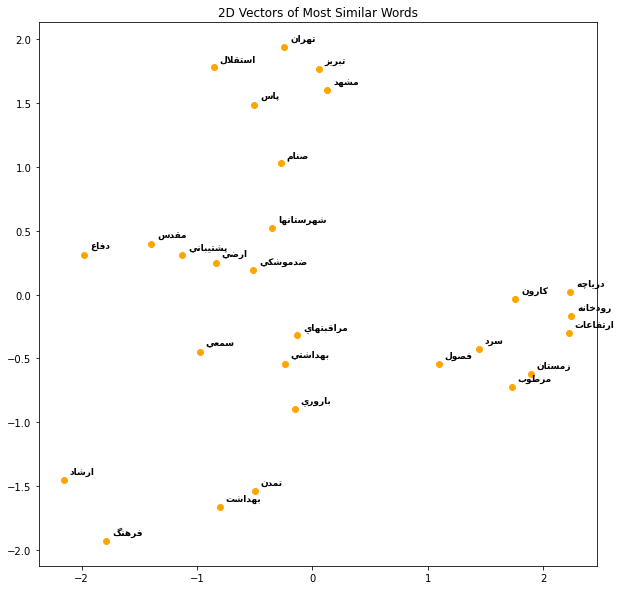

In [ ]:
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], color="orange")

for i, word in enumerate(selected_words):
  reshaped_text = arabic_reshaper.reshape(word)
  artext = get_display(reshaped_text)

  plt.text(vectors_2d[i, 0]+0.05, vectors_2d[i, 1]+0.05, artext, fontsize=9, weight="bold")

plt.gcf().set_size_inches(10,10)
plt.title("2D Vectors of Most Similar Words")
plt.show()

In [ ]:
pca_3d = PCA(n_components=3)

pca_3d.fit(vectors)

vectors_3d = pca_3d.transform(vectors)

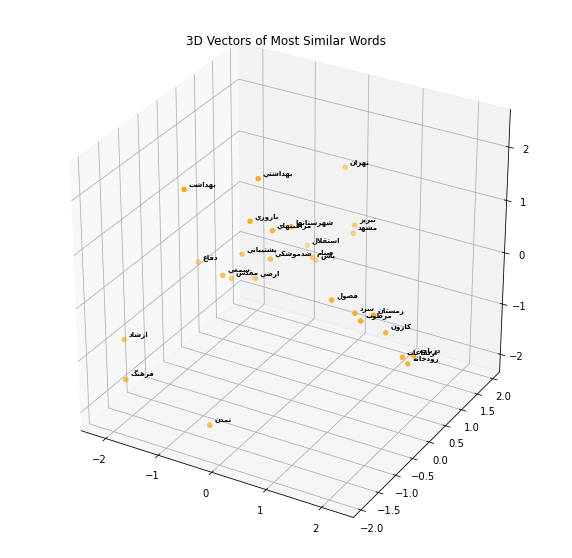

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(vectors_3d[:, 0], vectors_3d[:, 1], vectors_3d[:, 2], color="orange")

for i, word in enumerate(selected_words):
  reshaped_text = arabic_reshaper.reshape(word)
  artext = get_display(reshaped_text)

  ax.text(vectors_3d[i, 0]+0.05, vectors_3d[i, 1]+0.05, vectors_3d[i, 2]+0.05, artext, fontsize=7, weight="bold")

plt.gcf().set_size_inches(10,10)
plt.title("3D Vectors of Most Similar Words")
plt.show()